In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: sahaana (use `wandb login --relogin` to force relogin)


True

# Imports 

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
import sys
#sys.path.append('/lfs/1/sahaana/enrichment/enrich/utils')
sys.path.append('/lfs/1/sahaana/enrichment/ember/utils')
 
    
from embedding_datasets import SQuADDataset, EmberEvalDataset
from embedding_models import TripletSingleBERTModel
from embedding_utils import param_header, tokenize_batch  
from embedding_runner import train_model, eval_model
#from model_utils import MatchedDatasetTriplets, param_header_bert, tokenize_batch   
#from models import BatchedTripletSingleTowerModel, BatchedTripletSingleBERTModel
#from model_runner import train_model, eval_model
from knn_utils import FaissKNeighbors, knn_SQuAD_recall #, knn_matching_accuracy, find_perfect_recall

In [6]:
%load_ext autoreload
%autoreload 2

# Load Processed (cleaned, aligned) Datasets

In [7]:
left = '/lfs/1/sahaana/enrichment/data/SQuAD/train_tableA_processed.pkl'
right = '/lfs/1/sahaana/enrichment/data/SQuAD/train_tableB_sent_processed.pkl'

left = pd.read_pickle(left)
right = pd.read_pickle(right)

In [8]:
left

,question,merged_all
QID,,
0,When did Beyonce start becoming popular?,[SEP] question When did Beyonce start becomi...
1,What areas did Beyonce compete in when she was...,[SEP] question What areas did Beyonce compet...
2,When did Beyonce leave Destiny's Child and bec...,[SEP] question When did Beyonce leave Destin...
3,In what city and state did Beyonce grow up?,[SEP] question In what city and state did Be...
4,In which decade did Beyonce become famous?,[SEP] question In which decade did Beyonce b...
...,...,...
86816,In what US state did Kathmandu first establish...,[SEP] question In what US state did Kathmand...
86817,What was Yangon previously known as?,[SEP] question What was Yangon previously kn...
86818,With what Belorussian city does Kathmandu have...,[SEP] question With what Belorussian city do...


In [9]:
right

,sentence,merged_all
SID,,
2,"Born and raised in Houston, Texas, she perfor...","[SEP] sentence Born and raised in Houston, ..."
6,Their hiatus saw the release of Beyoncé's deb...,[SEP] sentence Their hiatus saw the release...
4,"Managed by her father, Mathew Knowles, the gr...","[SEP] sentence Managed by her father, Mathe..."
11,"Beyoncé also ventured into acting, with a Gol...",[SEP] sentence Beyoncé also ventured into a...
13,Her marriage to rapper Jay Z and portrayal of...,[SEP] sentence Her marriage to rapper Jay Z...
...,...,...
228258,A recent extension to the international termi...,[SEP] sentence A recent extension to the in...
228260,"Since 2013, Turkish Airlines connects Istanbu...","[SEP] sentence Since 2013, Turkish Airlines..."
228267,KMC's first international relationship was es...,[SEP] sentence KMC's first international re...


(array([8.6767e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

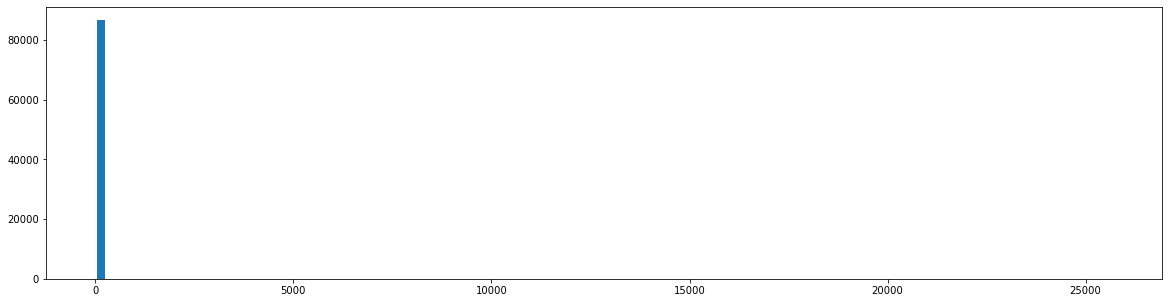

In [10]:
plt.figure(figsize=(20,5))
plt.hist(left['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

(array([1.920e+02, 3.520e+02, 5.120e+02, 8.880e+02, 1.697e+03, 2.206e+03,
        2.910e+03, 3.481e+03, 4.078e+03, 3.991e+03, 4.076e+03, 4.081e+03,
        4.129e+03, 3.650e+03, 3.279e+03, 2.938e+03, 2.858e+03, 2.254e+03,
        1.922e+03, 1.678e+03, 1.568e+03, 1.180e+03, 1.065e+03, 8.980e+02,
        7.640e+02, 5.600e+02, 4.590e+02, 4.040e+02, 3.760e+02, 2.850e+02,
        2.280e+02, 1.940e+02, 1.710e+02, 1.150e+02, 9.700e+01, 9.100e+01,
        9.300e+01, 5.900e+01, 5.800e+01, 5.000e+01, 3.200e+01, 2.800e+01,
        2.400e+01, 2.100e+01, 1.300e+01, 2.200e+01, 2.100e+01, 1.800e+01,
        1.800e+01, 9.000e+00, 1.300e+01, 3.000e+00, 5.000e+00, 0.000e+00,
        4.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

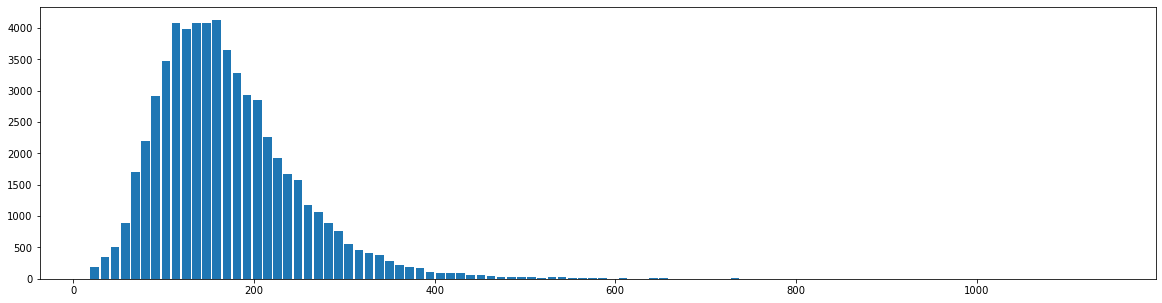

In [11]:
plt.figure(figsize=(20,5))
plt.hist(right['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

# Prepping Data Indices

In [12]:
train_df = '/lfs/1/sahaana/enrichment/data/SQuAD/train_sent_triplets.pkl'
train_df = pd.read_pickle(train_df)

val_df = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_sent_labels.pkl'
val_df = pd.read_pickle(val_df)

## Model H Params

In [13]:
epochs = 1
batch_size = 8
final_size = 200
lr = .00001
tl_margin = 1.0
tl_p = 2
pool_type = "CLS"
column = "merged_all"
shuffle = True
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_max_length = 512
compute_val = False
train_size = len(train_df)
    

bert_path='distilbert-base-uncased'
bert_model = DistilBertModel.from_pretrained(bert_path, return_dict=True)

model_name = f'SQuAD_sent-distilbert-base-uncased'

## DataLoaders

In [14]:
train_data = DataLoader(SQuADDataset(left, right, len(train_df), column, train_df), 
                        batch_size=batch_size,
                        shuffle = shuffle
                        )

val_data = None 
"""DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), 
                       batch_size=batch_size,
                       shuffle = False
                      )"""

'DataLoader(SQuADDataset(left, right, len(val_df), column, val_df), \n                       batch_size=batch_size,\n                       shuffle = False\n                      )'

## Init and Run Model

In [15]:
triplet_loss = nn.TripletMarginLoss(margin=tl_margin, p=tl_p)
losses = []
val_losses = []
model = TripletSingleBERTModel(final_size, pool_type, bert_path)
optimizer = optim.AdamW(model.parameters(), lr=lr)#optim.SGD(model.parameters(), lr=lr)

In [16]:
save_dir = param_header(batch_size, final_size, lr, pool_type, epochs, train_size)
save_dir = f'models/{model_name}/{save_dir}/'

In [17]:
wandb.init(project=model_name)

wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [18]:
train_model(model, 
            tokenizer, 
            tokenize_batch, 
            train_data, 
            val_data, 
            triplet_loss, 
            optimizer, 
            epochs, 
            losses, 
            val_losses, 
            save_dir, 
            compute_val, 
            tokenizer_max_length = tokenizer_max_length)

# k-NN Model Performance

In [19]:
left_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableA_processed.pkl'
right_eval = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_tableB_sent_processed.pkl'
test = '/lfs/1/sahaana/enrichment/data/SQuAD/dev_sent_labels.pkl'

left_eval = pd.read_pickle(left_eval)
right_eval = pd.read_pickle(right_eval)
test_df = pd.read_pickle(test)

In [20]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

left_eval_data = DataLoader(EmberEvalDataset(left_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )
right_eval_data = DataLoader(EmberEvalDataset(right_eval, column, indexed=True), 
                       batch_size=batch_size,
                       shuffle = False
                      )

In [21]:
left_index, left_embeddings = eval_model(model, tokenizer, left_eval_data, tokenizer_max_length=512)
right_index, right_embeddings = eval_model(model, tokenizer, right_eval_data, tokenizer_max_length=512)

In [22]:
knn = FaissKNeighbors(k=30)
knn.fit(right_embeddings)
neib = knn.kneighbors(left_embeddings)

In [23]:
for k in range(1,31):
    avg, count, MRR, results, MRR_results = knn_SQuAD_recall(neib[0], neib[1], test_df, left_index, right_index, 'SID', k=k)
    print(f"k: {k} \t avg: {avg} \t count: {count} \t MRR: {MRR}")

k: 1 	 avg: 0.5928113398582517 	 count: 3513 	 MRR: 0.5928113398582517
k: 2 	 avg: 0.6943975700303746 	 count: 4115 	 MRR: 0.6436044549443132
k: 3 	 avg: 0.745190685116436 	 count: 4416 	 MRR: 0.6605354933063337
k: 4 	 avg: 0.7725278434019575 	 count: 4578 	 MRR: 0.667369782877714
k: 5 	 avg: 0.7912588592642592 	 count: 4689 	 MRR: 0.6711159860501744
k: 6 	 avg: 0.8052649341883227 	 count: 4772 	 MRR: 0.6734503318708517
k: 7 	 avg: 0.8196085048936889 	 count: 4857 	 MRR: 0.6754994134001896
k: 8 	 avg: 0.8292271346608168 	 count: 4914 	 MRR: 0.6767017421210806
k: 9 	 avg: 0.837158285521431 	 count: 4961 	 MRR: 0.6775829811055933
k: 10 	 avg: 0.8486331420857239 	 count: 5029 	 MRR: 0.6787304667620226
k: 11 	 avg: 0.857408032399595 	 count: 5081 	 MRR: 0.6795281840632836
k: 12 	 avg: 0.8626392170097874 	 count: 5112 	 MRR: 0.679964116114133
k: 13 	 avg: 0.8680391495106311 	 count: 5144 	 MRR: 0.6803794955372748
k: 14 	 avg: 0.872595342558218 	 count: 5171 	 MRR: 0.6807049378978167
k: 15 	